In [10]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep  7 15:28:00 2020

@author: Frank
"""

from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import StructType, StructField, IntegerType, LongType
import codecs

def loadMovieNames():
    movieNames = {}
    # CHANGE THIS TO THE PATH TO YOUR u.ITEM FILE:
    with codecs.open("D:\\Spark\\Project_1_spark\\ml-100k\\u.item", "r", encoding='ISO-8859-1', errors='ignore') as f:
        for line in f:
            fields = line.split('|')
            movieNames[int(fields[0])] = fields[1]
    return movieNames

spark = SparkSession.builder.appName("PopularMovies").getOrCreate()

nameDict = spark.sparkContext.broadcast(loadMovieNames())

# Create schema when reading u.data
schema = StructType([ \
                     StructField("userID", IntegerType(), True), \
                     StructField("movieID", IntegerType(), True), \
                     StructField("rating", IntegerType(), True), \
                     StructField("timestamp", LongType(), True)])

# Load up movie data as dataframe
moviesDF = spark.read.option("sep", "\t").schema(schema).csv("D:\\Spark\\Project_1_spark\\ml-100k\\u.data")

movieCounts = moviesDF.groupBy("movieID").count()

# Create a user-defined function to look up movie names from our broadcasted dictionary
def lookupName(movieID):
    return nameDict.value[movieID]

lookupNameUDF = func.udf(lookupName)

# Add a movieTitle column using our new udf
moviesWithNames = movieCounts.withColumn("movieTitle", lookupNameUDF(func.col("movieID")))

# Sort the results
sortedMoviesWithNames = moviesWithNames.orderBy(func.desc("count"))

# Grab the top 20
sortedMoviesWithNames.show(20, False)

# Stop the session
spark.stop()


+-------+-----+--------------------------------+
|movieID|count|movieTitle                      |
+-------+-----+--------------------------------+
|50     |583  |Star Wars (1977)                |
|258    |509  |Contact (1997)                  |
|100    |508  |Fargo (1996)                    |
|181    |507  |Return of the Jedi (1983)       |
|294    |485  |Liar Liar (1997)                |
|286    |481  |English Patient, The (1996)     |
|288    |478  |Scream (1996)                   |
|1      |452  |Toy Story (1995)                |
|300    |431  |Air Force One (1997)            |
|121    |429  |Independence Day (ID4) (1996)   |
|174    |420  |Raiders of the Lost Ark (1981)  |
|127    |413  |Godfather, The (1972)           |
|56     |394  |Pulp Fiction (1994)             |
|7      |392  |Twelve Monkeys (1995)           |
|98     |390  |Silence of the Lambs, The (1991)|
|237    |384  |Jerry Maguire (1996)            |
|117    |378  |Rock, The (1996)                |
|172    |367  |Empir

###  Objectives: Most Popular Superhero Analysis with PySpark

1. **Create Spark Session**  
   Initialize a Spark application named `"MostPopularSuperhero"`.

2. **Define Schema for Names File**  
   Use `StructType` to define the schema of superhero names (ID and name).

3. **Load Superhero Names and Graph Data**  
   - Read `Marvel Names` with the custom schema.
   - Read `Marvel Graph`, a text file containing connections between heroes.

4. **Preprocess Graph Data**  
   - Split each line to extract the superhero ID and its connections.
   - Count number of connections per hero.

5. **Aggregate and Sort**  
   - Group data by ID and calculate total connections.
   - Sort in descending order to find the most connected (popular) superhero.

6. **Find Name of the Most Popular Hero**  
   - Match the ID with the names dataset.
   - Print out the name and number of co-appearances.


In [13]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

spark = SparkSession.builder.appName("MostPopularSuperhero").getOrCreate()

schema = StructType([ \
                     StructField("id", IntegerType(), True), \
                     StructField("name", StringType(), True)])

names = spark.read.schema(schema).option("sep", " ").csv("D:\\Spark\\Project_1_spark\\Marvel Names")

lines = spark.read.text("D:\\Spark\\Project_1_spark\\Marvel Graph")

# Small tweak vs. what's shown in the video: we trim each line of whitespace as that could
# throw off the counts.
connections = lines.withColumn("id", func.split(func.trim(func.col("value")), " ")[0]) \
    .withColumn("connections", func.size(func.split(func.trim(func.col("value")), " ")) - 1) \
    .groupBy("id").agg(func.sum("connections").alias("connections"))
    
mostPopular = connections.sort(func.col("connections").desc()).first()

mostPopularName = names.filter(func.col("id") == mostPopular[0]).select("name").first()

print(mostPopularName[0] + " is the most popular superhero with " + str(mostPopular[1]) + " co-appearances.")

CAPTAIN AMERICA is the most popular superhero with 1933 co-appearances.


# Movie Similarity System Using PySpark

## Objective
The goal of this project is to build a movie recommendation system using collaborative filtering. We want to find and display the top 10 movies that are most similar to a given movie, based on user rating patterns.

## Dataset Source
The dataset used in this project is from [MovieLens](https://movielens.org/), a popular open dataset for movie recommendation systems. Specifically, I use the **MovieLens 100k** dataset.

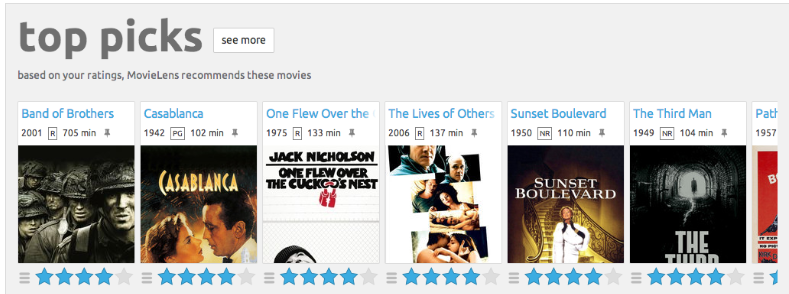


## What We Do in This Code
1. **Load Movie Metadata**
   - Read the list of all movies (`u.item`) using a custom schema and ISO-8859-1 encoding.

2. **Load User Ratings**
   - Read the user-movie rating data (`u.data`) using a defined schema.
   - Select only the relevant columns: user ID, movie ID, and rating.

3. **Generate Movie Pairs**
   - Join the ratings dataset with itself to create all movie pairs rated by the same user.
   - Extract rating pairs (rating1 and rating2) for those movie pairs.

4. **Compute Cosine Similarity**
   - Calculate cosine similarity for each movie pair using:
     - `numerator = sum(rating1 * rating2)`
     - `denominator = sqrt(sum(rating1^2)) * sqrt(sum(rating2^2))`
     - `score = numerator / denominator`

5. **Filter Similar Movies**
   - Set thresholds:
     - `scoreThreshold = 0.97`
     - `coOccurrenceThreshold = 50`
   - Filter for movie pairs with high similarity and strong co-occurrence.

6. **Display Top 10 Similar Movies**
   - Choose a target movie ID.
   - Return the top 10 most similar movies to that movie.
   - Show similarity `score` and co-rating `strength` (number of users who rated both movies).

## Expected Output
A list of the top 10 movies that are most similar to the selected movie (e.g., Star Wars), with:
- `score`: how similar the ratings are (between 0 and 1)
- `strength`: how many users rated both movies (higher = more reliable similarity)

Example:

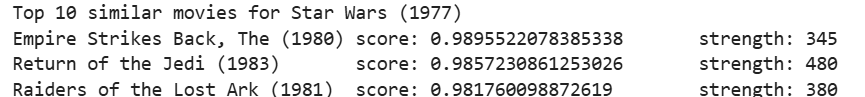


In [25]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType
import sys

def computeCosineSimilarity(spark, data):
    # Compute xx, xy and yy columns
    pairScores = data \
      .withColumn("xx", func.col("rating1") * func.col("rating1")) \
      .withColumn("yy", func.col("rating2") * func.col("rating2")) \
      .withColumn("xy", func.col("rating1") * func.col("rating2")) 

    # Compute numerator, denominator and numPairs columns
    calculateSimilarity = pairScores \
      .groupBy("movie1", "movie2") \
      .agg( \
        func.sum(func.col("xy")).alias("numerator"), \
        (func.sqrt(func.sum(func.col("xx"))) * func.sqrt(func.sum(func.col("yy")))).alias("denominator"), \
        func.count(func.col("xy")).alias("numPairs")
      )

    # Calculate score and select only needed columns (movie1, movie2, score, numPairs)
    result = calculateSimilarity \
      .withColumn("score", \
        func.when(func.col("denominator") != 0, func.col("numerator") / func.col("denominator")) \
          .otherwise(0) \
      ).select("movie1", "movie2", "score", "numPairs")

    return result

# Get movie name by given movie id 
def getMovieName(movieNames, movieId):
    result = movieNames.filter(func.col("movieID") == movieId) \
        .select("movieTitle").collect()[0]

    return result[0]


spark = SparkSession.builder.appName("MovieSimilarities").master("local[*]").getOrCreate()

movieNamesSchema = StructType([ \
                               StructField("movieID", IntegerType(), True), \
                               StructField("movieTitle", StringType(), True) \
                               ])
    
moviesSchema = StructType([ \
                     StructField("userID", IntegerType(), True), \
                     StructField("movieID", IntegerType(), True), \
                     StructField("rating", IntegerType(), True), \
                     StructField("timestamp", LongType(), True)])
    
    
# Create a broadcast dataset of movieID and movieTitle.
# Apply ISO-885901 charset
movieNames = spark.read \
      .option("sep", "|") \
      .option("charset", "ISO-8859-1") \
      .schema(movieNamesSchema) \
      .csv("D:\\Spark\\Project_1_spark\\ml-100k\\u.item")

# Load up movie data as dataset
movies = spark.read \
      .option("sep", "\t") \
      .schema(moviesSchema) \
      .csv("D:\\Spark\\Project_1_spark\\ml-100k\\u.data")


ratings = movies.select("userId", "movieId", "rating")

# Emit every movie rated together by the same user.
# Self-join to find every combination.
# Select movie pairs and rating pairs
moviePairs = ratings.alias("ratings1") \
      .join(ratings.alias("ratings2"), (func.col("ratings1.userId") == func.col("ratings2.userId")) \
            & (func.col("ratings1.movieId") < func.col("ratings2.movieId"))) \
      .select(func.col("ratings1.movieId").alias("movie1"), \
        func.col("ratings2.movieId").alias("movie2"), \
        func.col("ratings1.rating").alias("rating1"), \
        func.col("ratings2.rating").alias("rating2"))


moviePairSimilarities = computeCosineSimilarity(spark, moviePairs).cache()

if (len(sys.argv) > 1):
    scoreThreshold = 0.97
    coOccurrenceThreshold = 50.0

    movieID = 50

    # Filter for movies with this sim that are "good" as defined by
    # our quality thresholds above
    filteredResults = moviePairSimilarities.filter( \
        ((func.col("movie1") == movieID) | (func.col("movie2") == movieID)) & \
          (func.col("score") > scoreThreshold) & (func.col("numPairs") > coOccurrenceThreshold))

    # Sort by quality score.
    results = filteredResults.sort(func.col("score").desc()).take(10)
    
    print ("Top 10 similar movies for " + getMovieName(movieNames, movieID))
    
    for result in results:
        # Display the similarity result that isn't the movie we're looking at
        similarMovieID = result.movie1
        if (similarMovieID == movieID):
          similarMovieID = result.movie2
        
        print(getMovieName(movieNames, similarMovieID) + "\tscore: " \
              + str(result.score) + "\tstrength: " + str(result.numPairs))


Top 10 similar movies for Star Wars (1977)
Empire Strikes Back, The (1980)	score: 0.9895522078385338	strength: 345
Return of the Jedi (1983)	score: 0.9857230861253026	strength: 480
Raiders of the Lost Ark (1981)	score: 0.981760098872619	strength: 380
20,000 Leagues Under the Sea (1954)	score: 0.9789385605497993	strength: 68
12 Angry Men (1957)	score: 0.9776576120448436	strength: 109
Close Shave, A (1995)	score: 0.9775948291054827	strength: 92
African Queen, The (1951)	score: 0.9764692222674887	strength: 138
Sting, The (1973)	score: 0.9751512937740359	strength: 204
Wrong Trousers, The (1993)	score: 0.9748681355460885	strength: 103
Wallace & Gromit: The Best of Aardman Animation (1996)	score: 0.9741816128302572	strength: 58
